In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Lambda, Convolution1D, LSTM, SimpleRNN
from keras.utils import to_categorical

keras.__version__

'2.3.1'

# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [5]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

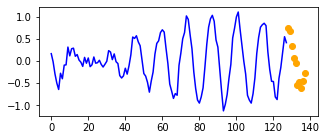

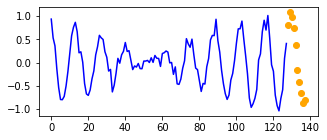

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [25]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate


### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 features. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

In [21]:
def slice(x, slice_length):
    return x[:, -slice_length:, :]

In [63]:
model1 = Sequential()

# Input layer
model1.add(Conv1D(32, kernel_size = 5, input_shape = (None, 1), padding = "causal"))
model1.add(Conv1D(32, kernel_size = 5, padding = "causal", activation = "relu"))
model1.add(Conv1D(32, kernel_size = 5, padding = "causal", activation = "relu"))
model1.add(Conv1D(32, kernel_size = 5, padding = "causal", activation = "relu"))

# Output layer
model1.add(Dense(1))
model1.add(Lambda(slice, arguments = {'slice_length': look_ahead}))

model1.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_58 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_18 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_9 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

- first 800 sequences for training 
- last 200 for validation
- mean squared error (MSE) (should get a MSE of approx 0.02 to 0.03)

In [64]:
X, Y = gen_data()
# Training data
x_train = X[:800]
y_train = Y[:800]

# Validation data
x_valid = X[800:]
y_valid = Y[800:]

In [65]:
model1.compile(optimizer = "sgd", loss = "mse", metrics = ["acc"])
model1.fit(x_train, y_train, epochs = 25, batch_size = 10)

Epoch 1/25
800/800 [==============================] - 2s 2ms/step - loss: 0.1314 - acc: 0.0000e+00
Epoch 2/25
800/800 [==============================] - 1s 2ms/step - loss: 0.0398 - acc: 0.0000e+00
Epoch 3/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0375 - acc: 0.0000e+00
Epoch 4/25
800/800 [==============================] - 1s 2ms/step - loss: 0.0363 - acc: 0.0000e+00
Epoch 5/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0351 - acc: 0.0000e+00
Epoch 6/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0341 - acc: 0.0000e+00
Epoch 7/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0331 - acc: 0.0000e+00
Epoch 8/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0323 - acc: 0.0000e+00
Epoch 9/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0316 - acc: 0.0000e+00
Epoch 10/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0309 - acc: 0.0000e+00
Epoch 11/

### Make repeated predictions

Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [53]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model1.predict(x_test).reshape(-1) #Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([ 0.07126223,  0.15853435,  0.26138735,  0.36336154,  0.4088331 ,
        0.36845928,  0.2563594 ,  0.09638539, -0.05657604, -0.18457776],
      dtype=float32)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future. 

In [ ]:
def predict

## B) 1D Convolution with dilation rate

Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)
Build the same network as in A) but this time with dilation_rates 1,2,4,8 

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

### Make repeated predictions
As in A) make preaded preditions on noise less data.

## D) LSTM Cell
Repeat C) but now with an LSTM cell.